# This notebook is used to evaluate the performance of trained model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor, ToPILImage
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import yaml
import glob
import re
from collections import defaultdict
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report

torch.set_default_dtype(torch.float64)

In [3]:
from oil_seep_detection.trainer import LitUNet
from oil_seep_detection.datasets import SARDataset
from oil_seep_detection.utils import rescale_mask, colorize_mask

In [4]:
DATA_PATH = os.path.join(os.getcwd(), "data")
NUM_CLASSES = 8

LOG_DIR = "logs"
EXPERIMENT_NAME = "oil_seep_detection_dice_mse_loss"
VERSION = 3

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
metrics = pd.read_csv(
    os.path.join(
        os.getcwd(), 
        LOG_DIR, 
        EXPERIMENT_NAME, 
        f"version_{VERSION}",
        "metrics.csv"))

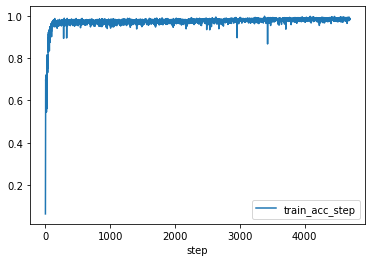

In [6]:
metrics[["step", "train_acc_step"]].dropna().plot.line(x="step", y="train_acc_step")
plt.show()

In [7]:
metrics.columns

Index(['train_dice_loss_step', 'train_mse_loss_step', 'train_total_loss_step',
       'train_acc_step', 'epoch', 'step', 'val_dice_loss_step',
       'val_mse_loss_step', 'val_total_loss_step', 'val_acc_step',
       'val_dice_loss_epoch', 'val_mse_loss_epoch', 'val_total_loss_epoch',
       'val_acc_epoch', 'train_dice_loss_epoch', 'train_mse_loss_epoch',
       'train_total_loss_epoch', 'train_acc_epoch'],
      dtype='object')

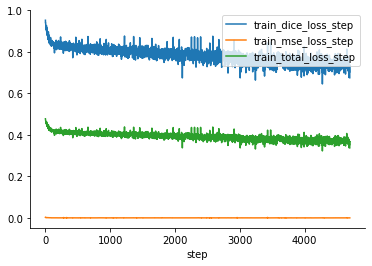

In [8]:
fig, ax = plt.subplots()
metrics[["step", "train_dice_loss_step"]].dropna().plot.line(x="step", y="train_dice_loss_step", ax=ax)
metrics[["step", "train_mse_loss_step"]].dropna().plot.line(x="step", y="train_mse_loss_step", ax=ax)
metrics[["step", "train_total_loss_step"]].dropna().plot.line(x="step", y="train_total_loss_step", ax=ax)
sns.despine(ax=ax)

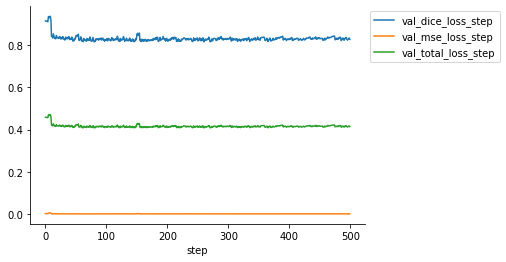

In [9]:
fig, ax = plt.subplots()
metrics[["step", "val_dice_loss_step"]].dropna().plot.line(x="step", y="val_dice_loss_step", ax=ax)
metrics[["step", "val_mse_loss_step"]].dropna().plot.line(x="step", y="val_mse_loss_step", ax=ax)
metrics[["step", "val_total_loss_step"]].dropna().plot.line(x="step", y="val_total_loss_step", ax=ax)
sns.despine(ax=ax)
plt.legend(bbox_to_anchor=(1.,1.))
plt.show()

# Loading and evaluating best model weights (criteria - minimum validation loss)

In [10]:
DIR = os.path.join(LOG_DIR, EXPERIMENT_NAME, f"version_{VERSION}")
hparams = yaml.safe_load(open(os.path.join(DIR, "hparams.yaml")))
chk_pth = os.path.join(DIR, "checkpoints")
chk_pth = glob.glob(f"{chk_pth}/*.ckpt")[0]

In [11]:
chk_pth

'logs/oil_seep_detection_dice_mse_loss/version_3/checkpoints/epoch=54-step=2584-val_total_loss=0.411-val_acc=0.972.ckpt'

In [12]:
best_model_epoch = int(re.findall(r"epoch=\d+", chk_pth)[0].split("=")[-1])
best_model_step = int(re.findall(r"step=\d+", chk_pth)[0].split("=")[-1])
print(f"Best model epoch at {best_model_epoch} and step at {best_model_step}")

Best model epoch at 54 and step at 2584


In [13]:
lit_unet = LitUNet(
    in_channels= hparams["in_channels"],
    mid_channels= hparams["mid_channels"],
    out_channels= hparams["out_channels"],
    kernel_size= hparams["kernel_size"],
    stride= hparams["stride"],
    padding= hparams["padding"],
    padding_mode=hparams["padding_mode"],
    norm=hparams["norm"],
    activation=hparams["activation"],
    dice_coeff=hparams["dice_coeff"],
    lr=hparams["lr"],
    val_mask_dir=hparams["val_mask_dir"], 
    class_weights=hparams["class_weights"])

In [14]:
# loading best model
lit_unet.load_state_dict(torch.load(chk_pth)["state_dict"])
unet = lit_unet.unet.cuda()

In [15]:
test_ds = SARDataset(
    img_dir=os.path.join(DATA_PATH, "test", "images"), 
    mask_dir=os.path.join(DATA_PATH, "test", "masks"),
    num_classes=NUM_CLASSES) 
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False,)

In [16]:
# Evaluate model at test set
unet.eval()

pred_masks = []
true_masks = []
# DEVICE = "cpu"

with torch.no_grad():
    for idxs, imgs, masks in tqdm(test_dl, leave=False, position=0):
        imgs = imgs.to(DEVICE)
    
        pred_masks.append(unet(imgs).cpu())
        true_masks.append(masks)
        
pred_masks = torch.vstack(pred_masks)
true_masks = torch.vstack(true_masks)

In [17]:
pred_masks.shape, true_masks.shape

(torch.Size([80, 8, 256, 256]), torch.Size([80, 8, 256, 256]))

Left True mask, Right Predicted Mask


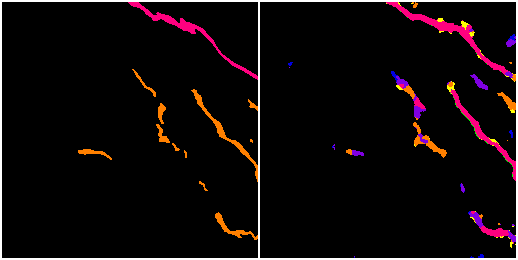

In [27]:
idx = 16
print("Left True mask, Right Predicted Mask")
ToPILImage()(
    make_grid([
        colorize_mask(torch.argmax(true_masks[idx], dim=0, keepdim=True)),
        colorize_mask(torch.argmax(pred_masks[idx], dim=0, keepdim=True))], pad_value=1.0))

In [28]:
pred_labels = dict()
true_labels = dict()
for cl in tqdm(range(NUM_CLASSES), leave=False, position=0):
    pred_labels[cl] = pred_masks[:,cl,:,:].flatten()
    true_labels[cl] = true_masks[:,cl,:,:].flatten()

In [29]:
fprs, tprs, aucs = dict(), dict(), dict()
for cl in tqdm(range(NUM_CLASSES), leave=False, position=0):
    fpr, tpr, _ =  roc_curve(true_labels[cl], pred_labels[cl])
    fprs[cl] = fpr
    tprs[cl] = tpr
    aucs[cl] = auc(fpr, tpr)

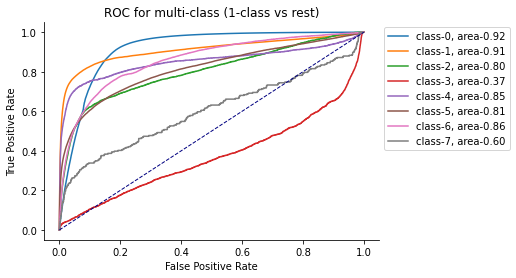

In [30]:
fig, ax = plt.subplots()
for cl in range(NUM_CLASSES):
    ax.plot(fprs[cl], tprs[cl], label=f"class-{cl}, area-{aucs[cl]:.2f}")
ax.plot([0, 1], [0, 1], color='navy', lw=1., linestyle='--')
ax.legend(bbox_to_anchor=[1.0,1.])
ax.set_ylabel("True Positive Rate")
ax.set_xlabel("False Positive Rate")
ax.set_title("ROC for multi-class (1-class vs rest)")
sns.despine(ax=ax)

In [32]:
true = torch.argmax(true_masks, dim=1, keepdim=True)
pred = torch.argmax(pred_masks, dim=1, keepdim=True)
accuracy = (true == pred).sum()/np.prod(list(true.size()))

In [33]:
report = classification_report(
    true.numpy().astype(np.uint8).ravel(), 
    pred.numpy().astype(np.uint8).ravel(), 
    labels=np.arange(NUM_CLASSES))
print(report)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98   5112703
           1       0.46      0.51      0.48     70001
           2       0.02      0.19      0.03      4275
           3       0.00      0.00      0.00      2209
           4       0.07      0.26      0.12      3394
           5       0.21      0.24      0.22     34971
           6       0.06      0.09      0.07     15061
           7       0.00      0.00      0.00       266

    accuracy                           0.96   5242880
   macro avg       0.23      0.28      0.24   5242880
weighted avg       0.97      0.96      0.97   5242880



# Conclusion and improvements

Since the data is highly imbalanced in terms of labels for pixels in masks, therefore model seem to be underperforming.
Weighted loss functions did not seem to be significantly overcoming the class imbalance issue.

1. We can try sampling images with masks which have comparatively balance distribution of classes.
1. We can also use data augmentation and model regularization methods to reduce underperforming of current model